# 2. Data preparation

---

### Setup

In [2]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../heart_failure_clinical_records_dataset_after_profiling.csv', sep=';')
original.to_csv('original.csv', sep=';', index=False)

cols_nr = original.select_dtypes(include='number')
cols_sb = original.select_dtypes(include='bool')

original.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

In [3]:
df_nr = cols_nr
df_sb = cols_sb

### Outliers Removal

---

In [4]:
# TODO

Q1 = df_nr.quantile(0.25)
Q3 = df_nr.quantile(0.75)
IQR = Q3 - Q1

df_nr_no = df_nr[~((df_nr < (Q1 - 1.5 * IQR)) |(df_nr > (Q3 + 1.5 * IQR))).any(axis=1)]

df_no = pd.concat((df_nr_no, df_sb), axis=1).dropna()
print(df_no)

      age  creatinine_phosphokinase  ejection_fraction  platelets  \
0    75.0                     582.0               20.0   265000.0   
2    65.0                     146.0               20.0   162000.0   
3    50.0                     111.0               20.0   210000.0   
5    90.0                      47.0               40.0   204000.0   
6    75.0                     246.0               15.0   127000.0   
..    ...                       ...                ...        ...   
291  60.0                     320.0               35.0   133000.0   
292  52.0                     190.0               38.0   382000.0   
293  63.0                     103.0               35.0   179000.0   
294  62.0                      61.0               38.0   155000.0   
298  50.0                     196.0               45.0   395000.0   

     serum_creatinine  serum_sodium   time  anaemia  diabetes  \
0                 1.9         130.0    4.0    False     False   
2                 1.3         129.0    7.

In [10]:
df_no.to_csv('prepared_no.csv', sep=';', index=False)

prepared_no was better

### Scaling

---

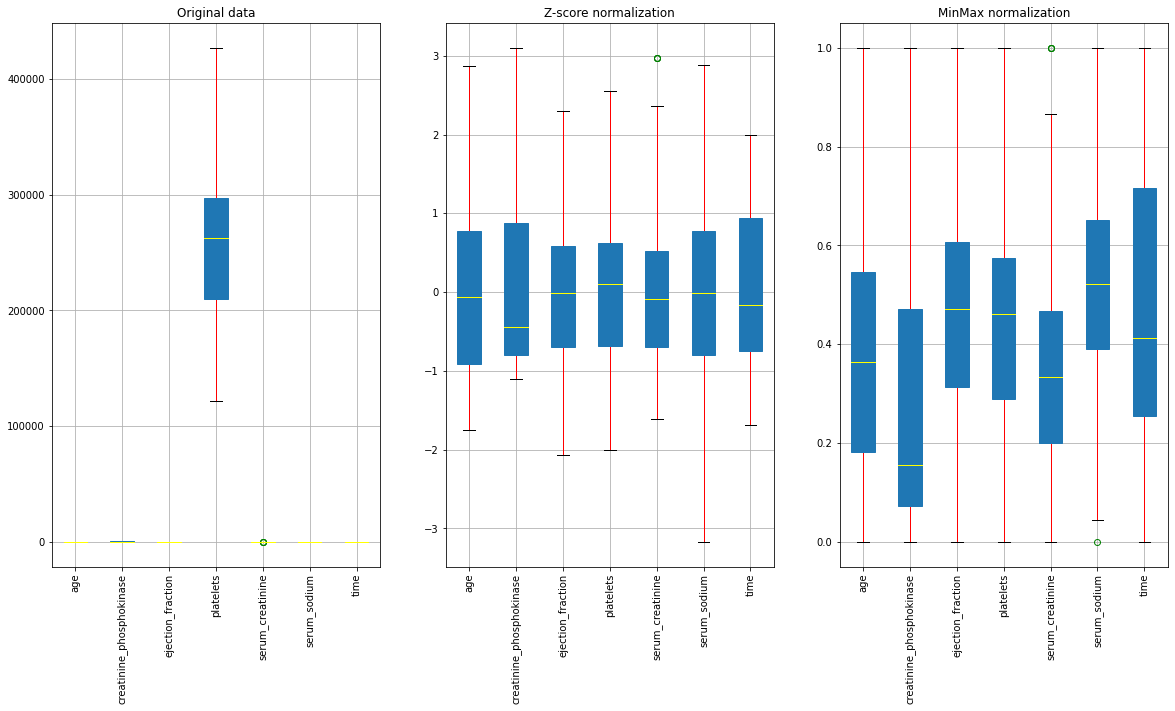

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_no_nr = df_no.select_dtypes(include='number')
data_no_sb = df_no.select_dtypes(include='bool').reset_index().drop(columns='index')

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data_no_nr)
norm_data_zscore = pd.DataFrame(transf.transform(data_no_nr), columns= data_no_nr.columns)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_no_nr)
norm_data_minmax = pd.DataFrame(transf.transform(data_no_nr), columns= data_no_nr.columns)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 1, ncols=3, figsize=(20, 10),squeeze=False)
axs[0, 0].set_title('Original data')
data_no_nr.boxplot(ax=axs[0, 0], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2], rot=90, patch_artist=True, whiskerprops=dict(color='red'), medianprops=dict(color='yellow'), flierprops=dict(color='green', markeredgecolor='green'))
plt.show()

In [6]:
# Rejoin numeric with symbolic variables
norm_data_zscore = norm_data_zscore.join(data_no_sb, how='right')
norm_data_minmax = norm_data_minmax.join(data_no_sb, how='right')


norm_data_zscore.to_csv('prepared_zs.csv', sep=';', index=False)
norm_data_minmax.to_csv('prepared_mm.csv', sep=';', index=False)

prepared_no was best

### Data balancing

---

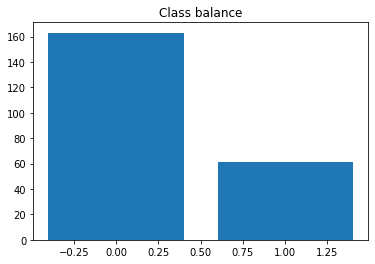

Minority class: 61
Majority class: 163
Proportion: 0.374 : 1


In [7]:
import matplotlib.pyplot as plt

unbal = norm_data_zscore[:]
target_count = unbal['DEATH_EVENT'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

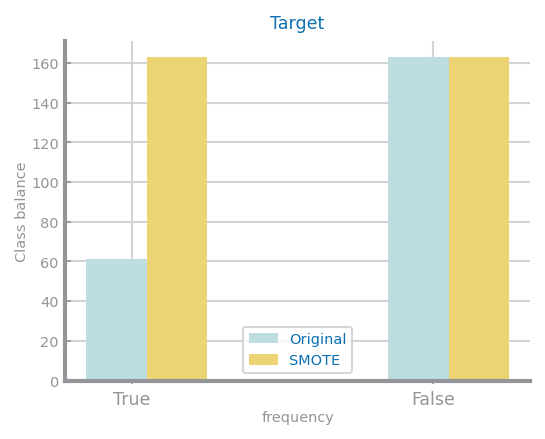

In [8]:
import ds_functions as ds
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = unbal.pop('DEATH_EVENT').values
X = unbal.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

In [9]:
import numpy as np
smote_data = pd.DataFrame(np.concatenate([smote_X, smote_y[:,None]], axis=1), columns=df_no.columns)

bool_names = ('anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT')
for name in bool_names:
    for i in range(len(smote_data[name])):
        smote_data[name][i] = (smote_data[name][i] >= 0.5)
smote_data = smote_data.astype({
    'anaemia': bool, 
    'diabetes': bool, 
    'high_blood_pressure': bool, 
    'sex': bool,
    'smoking': bool,
    'DEATH_EVENT': bool
})
# Finally, export prepared data to csv
smote_data.to_csv('prepared_zs_b.csv', sep=';', index=False)

not sure between prepared_b and prepared_no

### Feature Generation

---

In [10]:
df_gen = smote_data

df_gen_nr = df_gen.select_dtypes(include='number')

op_names = ('sum', 'diff', 'prod')
ops = (lambda x,y: x+y, lambda x,y: x-y, lambda x,y: x*y)

new_df_gen_nr = pd.DataFrame()

index = 0
for o in range(len(ops)):
    for col1 in df_gen_nr.columns:
        for col2 in df_gen_nr.columns:
            if col1 == col2:
                break
            new_col = ops[o](df_gen_nr[col1], df_gen_nr[col2])
            name = op_names[o] + '(' + col1 + ',' + col2 + ')'
            new_df_gen_nr.insert(index, name, new_col)
            index += 1

new_df_gen = new_df_gen_nr.join(df_gen, how='right')
print(new_df_gen)

     sum(creatinine_phosphokinase,age)  sum(ejection_fraction,age)  \
0                             2.069207                   -0.365231   
1                            -0.333066                   -1.204200   
2                            -1.717014                   -2.462654   
3                             1.409386                    2.604873   
4                             0.864459                   -0.793143   
..                                 ...                         ...   
321                           2.778235                    1.504159   
322                           0.783684                   -0.701330   
323                          -0.644959                   -0.990827   
324                          -0.157475                   -0.989708   
325                           2.164063                    0.655823   

     sum(ejection_fraction,creatinine_phosphokinase)  sum(platelets,age)  \
0                                          -0.677097            1.326870   
1      

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [11]:
import seaborn as sns
import numpy as np

copy = new_df_gen.copy(deep=True)
copy = copy.drop('DEATH_EVENT', axis = 1)
corr_mtx_copy = copy.corr()

removed = []

for x in corr_mtx_copy:
    for y in corr_mtx_copy:
        if x == y:
            break
        corr = corr_mtx_copy[x][y]
        if abs(corr) >= 0.9 and x not in removed and y not in removed:
            copy = copy.drop(x, axis=1)
            removed.append(x)
            break

copy['DEATH_EVENT'] = new_df_gen['DEATH_EVENT']
y: np.ndarray = copy['DEATH_EVENT'].values
X: np.ndarray = copy.drop('DEATH_EVENT', axis=1).values

In [129]:
print(copy)

     sum(creatinine_phosphokinase,age)  sum(ejection_fraction,age)  \
0                             1.107353                    0.754011   
1                             0.553522                    0.572193   
2                             0.250931                    0.299465   
3                             0.923596                    1.418895   
4                             0.820664                    0.655971   
..                                 ...                         ...   
321                           1.403386                    1.311083   
322                           0.941089                    0.939838   
323                           0.598671                    0.748921   
324                           0.611234                    0.618408   
325                           0.639425                    1.439375   

     sum(ejection_fraction,creatinine_phosphokinase)  sum(platelets,age)  \
0                                           0.588637            1.105216   
1      

#### Supervised Selection


In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.
We will use sequential backward selection to select our sets of variables.

In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

bestAvgScore = 0
bestSet = None
bestNeighbors = -1

for n_neighbors in range(1, 9):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    sbfs = SFS(knn,
               k_features=12,
               forward=True,
               floating=False,
               scoring='accuracy',
               cv=10,
               n_jobs=-1)
    sbfs = sbfs.fit(X, y, custom_feature_names=copy.drop('DEATH_EVENT', axis=1).columns)

    for subset in sbfs.subsets_:
        if (sbfs.subsets_[subset]['avg_score'] > bestAvgScore):
            bestAvgScore = sbfs.subsets_[subset]['avg_score']
            bestSet = sbfs.subsets_[subset]['feature_names']
            bestNeighbors = n_neighbors
        
print('Best Set:', bestSet)
print('Accuracy:', bestAvgScore)
print('Nº neighbors:', bestNeighbors)

Best Set: ('sum(time,serum_creatinine)', 'diff(ejection_fraction,age)', 'diff(serum_sodium,platelets)', 'diff(time,serum_creatinine)', 'prod(platelets,ejection_fraction)', 'prod(serum_creatinine,creatinine_phosphokinase)', 'prod(time,platelets)', 'serum_creatinine', 'time')
Accuracy: 0.9423295454545455
Nº neighbors: 1


In [13]:
for feature in copy.columns:
    if feature not in bestSet and feature != 'DEATH_EVENT':
        copy = copy.drop(feature, axis=1)

In [14]:
copy.to_csv('prepared_zs_b_gs.csv', sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

No, the numeric variables have different scales. After applying scaling, the results (with Naive Bayes algorithm) were similar, but slightly worse. After removing the outliers, the results were slightly better.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is unbalanced. To balance it we used SMOTE, an oversampling technique.

### Feature Extraction

---

#### Principal component analysis


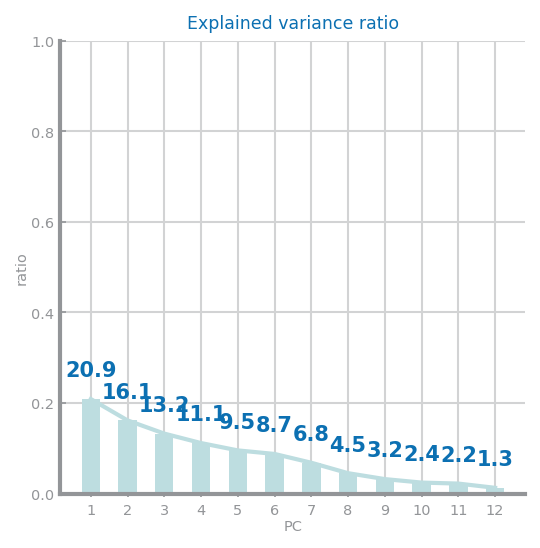

In [17]:
target_data = smote_data.pop('DEATH_EVENT')
data = smote_data

from sklearn.decomposition import PCA

mean = (data.mean(axis=0)).tolist()
centered_data = data - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = np.linalg.eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(4, 4))
plt.title('Explained variance ratio')
plt.xlabel('PC')
plt.ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = plt.gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
plt.show()

In [18]:
transf = pca.transform(data)
data = pd.DataFrame(transf[:,:7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])

data = data.join(target_data, how='right')

print(data)

data.to_csv('prepared_zs_b_fe.csv', sep=';', index=False)

          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    4.033492 -0.214008  0.339120  0.775288 -0.030280  0.438730 -0.135198   
1    2.685804 -0.393127 -1.673627 -0.122292 -1.627084  0.340844  0.439031   
2    2.369708 -0.246682 -1.837349  0.311681  0.252490 -0.798177 -1.892441   
3    3.495159 -2.352105  0.717934  0.299004 -1.073892 -1.446850 -0.507777   
4    2.257648 -1.276990 -1.858209 -1.373779 -0.036434 -0.041643  0.575194   
..        ...       ...       ...       ...       ...       ...       ...   
321  2.864242 -0.701396  1.212934 -0.161407  0.130472 -0.563215 -0.019546   
322  1.366937  0.078211 -0.497587  0.001755  0.353699 -0.140321  0.776810   
323  1.918907 -0.290829 -0.905151  0.348098 -0.156122 -0.909853 -0.748790   
324  0.599654 -1.140313 -1.545068  0.014332  0.910664  0.689570  0.451795   
325  2.866842 -0.675165  0.947407  0.431630  0.247802  0.360779 -0.553631   

     DEATH_EVENT  
0           True  
1           True  
2           True  